In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%precision %.4f

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("D:\INSTALL\SPbU\ML\dementia_dataset.csv")
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


Features Description

Subject ID	Subject identification number

MRI ID	Image identification number of an individual subject

Visit	Number of subject visits

Gender	Male/Female

Hand	Right/Left handed

EDUC	Subject education level (in years)

SES	Socioeconomic status

MMSE	Mini-mental state examination score

CDR	Clinical dementia rating score

eTIV	Estimated total intracranial volume result

nWBV	Normalized whole brain volume result

ASF	Atlas scaling factor

Age	Subject age while scanning

Group	Demented/Nondemented/Converted

MR delay	Magnetic resonance (MR) delay is the delay time that is prior to the image procurement

In [3]:
df.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

Восстанавливать предстоит значения SES - рейтинга социально-экономического благосостояния (1 - самый "бедный", 5 - самый "богатый").
Предсказывать интереснее всего признак Demented - есть ли у человека деменция, относительно остальных признаков.

In [4]:
df['Group'].value_counts()

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

Converted означает, что человек изначально был обозначен как Nondemented, однако в процессе исследования статус изменился.
В рамках данной работы будет разумно перевести всех Converted в категорию Demented.

In [5]:
df['Group'].replace('Converted', 'Demented', inplace=True)

In [6]:
df.groupby(['M/F', 'Group'])['Group'].count()

M/F  Group      
F    Demented        84
     Nondemented    129
M    Demented        99
     Nondemented     61
Name: Group, dtype: int64

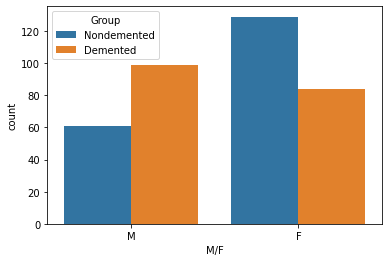

In [7]:
sns.countplot('M/F',hue='Group',data=df);

Как можно заметить, мужчины гораздо чаще подвержены деменции, нежели женщины, в рамках возрастной категории 60-96.

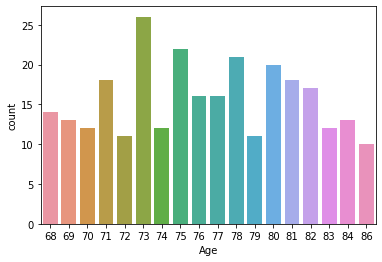

In [8]:
sns.countplot('Age', data=df, order=sorted(df['Age'].value_counts().iloc[:18].index));

Большинство испытуемых принадлежат к возрастным группам 73-75 и 78-82

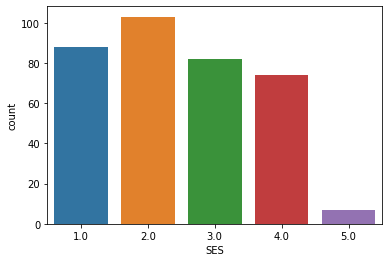

In [9]:
sns.countplot('SES', data=df);

Основная масса испытуемых принадлежит к классам с первого по 4. Незаполненных значений всего 19 из почти четырёхста. Пустые
значения можно заполнить случайными значениями в диапазоне [1,4], это практически не повлияет на статистику, но позволит
избавиться от пустот.

In [10]:
df['SES'].apply(lambda l: l if not np.isnan(l) else np.random.choice([1, 2, 3, 4]))

0      2.0
1      2.0
2      4.0
3      2.0
4      1.0
      ... 
368    1.0
369    1.0
370    2.0
371    2.0
372    2.0
Name: SES, Length: 373, dtype: float64

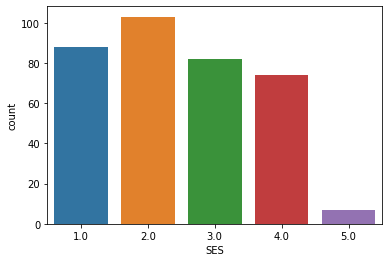

In [11]:
sns.countplot('SES', data=df);

Распределение действительно особо не изменилось, но пустот более нет, можно спокойно работать с данными.

In [12]:
df['Hand'].value_counts()

R    373
Name: Hand, dtype: int64

Значение Hand у всех одинаково, поэтому его смело можно исключить.

In [13]:
df.drop(columns=['Hand'], inplace=True)

Признак "Пол" необходимо перевести в числовую форму для дальнейшего анализа.

In [16]:
df['M/F'].replace(['M', 'F'], [0, 1], inplace=True)

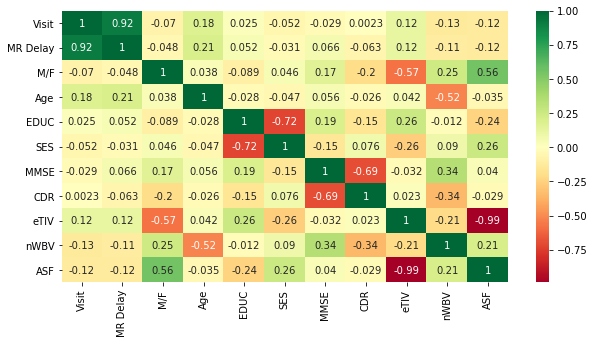

In [17]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Встречаются пары значений как с высокой положительной, так и с высокой отрицательной корреляцией. У пары Visit|MR Delay
высокая положительная корреляция, а у пар SES|EDUC, CDR|MMSE, eTIV|ASF высока отрицательная корреляция. По одному параметру
из перечисленных пар необходимо исключить.

In [18]:
df.drop(columns=['Visit', 'EDUC', 'MMSE', 'ASF'], inplace=True)

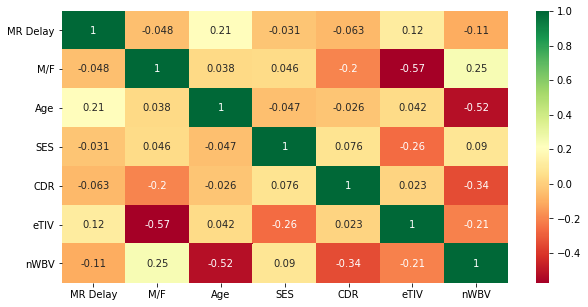

In [19]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Теперь корреляционная картина гораздо лучше походит для дальнейшей работы. Все ещё остаются пары признаков Age|nWBV, M/F|eTIV, но их корреляция не настолько сильна, чтобы выбрасывать один из признаков.